# EYE FOR BLIND
This notebook will be used to prepare the capstone project 'Eye for Blind'

In [1]:
try:
    # Check if running in fresh jupyter container (CodeSpace environment, for example)
    import pandas as pd
except ImportError:
    # Fresh jupyter environment, install additional libraries
    !pip install -q pandas matplotlib scikit-learn tensorflow keras-preprocessing wordcloud nltk gTTS

In [2]:
#Import all the required libraries

import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.models import Model

try:
    from tensorflow.keras.preprocessing.text import Tokenizer, tokenizer_from_json
except ImportError:
    from keras_preprocessing.text import Tokenizer, tokenizer_from_json

try:
    from nltk.translate.bleu_score import sentence_bleu
except ImportError:
    !pip install -q nltk
    from nltk.translate.bleu_score import sentence_bleu

try:
    import keras_tuner
except ImportError:
    !pip install -q keras-tuner
    import keras_tuner

from collections import Counter

from matplotlib import pyplot as plt
from PIL import Image
from IPython.display import Image as IPyImage
from IPython.display import Audio as IPYAudio
# Install wordcloud for TPU environment
try:
    from wordcloud import WordCloud
except ImportError:
    !pip install -q wordcloud
    from wordcloud import WordCloud

try:
    from gtts import gTTS
except ImportError:
    !pip install -q gTTS
    from gtts import gTTS

import os
import glob
import time
import re
import cv2
import json

import warnings
warnings.filterwarnings('ignore')

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


Let's read the dataset

## Data understanding
1.Import the dataset and read image & captions into two seperate variables

2.Visualise both the images & text present in the dataset

3.Create a dataframe which summarizes the image, path & captions as a dataframe

4.Create a list which contains all the captions & path

5.Visualise the top 30 occuring words in the captions



In [3]:
# Use TPU to speed up training
if tpus := tf.config.list_logical_devices('TPU'):
    resolver = tf.distribute.cluster_resolver.TPUClusterResolver()
    tf.config.experimental_connect_to_cluster(resolver)
    # This is the TPU initialization code that has to be at the beginning.
    tf.tpu.experimental.initialize_tpu_system(resolver)

    strategy = tf.distribute.TPUStrategy(resolver)

    display('Running on TPU')
    display(tpus)
elif gpus := tf.config.list_logical_devices('GPU'):
    strategy = tf.distribute.MirroredStrategy()
    display('Running on GPU')
    display(gpus)
else:
    strategy = tf.distribute.get_strategy()
    display('No GPU available')

'Running on GPU'

[LogicalDevice(name='/device:GPU:0', device_type='GPU'),
 LogicalDevice(name='/device:GPU:1', device_type='GPU')]

In [4]:
# Define directories (use /kaggle/working for writable paths)
project_dir = '/kaggle/working'
input_dir = f'{project_dir}/input'
out_dir = f'{project_dir}/output'
features_dir = f'{project_dir}/features'
checkpoint_dir = f'{project_dir}/checkpoints'
checkpoint_path = f'{checkpoint_dir}/train'
checkpoint_finetune_path = f'{checkpoint_dir}/finetune'

# Check if input is already prepared
if not os.path.exists(f'{input_dir}/flickr8k'):
    # Check if zip file is already downloaded, if not, download using kaggle cli
    if not os.path.exists(f'{project_dir}/flickr8k.zip'):
        !pip install -q kaggle
        !kaggle datasets download -q -p "{project_dir}" adityajn105/flickr8k
    
    # Use Python to count the number of files in the zip
    with zipfile.ZipFile(f'{project_dir}/flickr8k.zip', 'r') as zip_ref:
        n_files = len(zip_ref.infolist())
    
    # Extract the files into /kaggle/working/input (writable directory)
    os.makedirs(f'{input_dir}/flickr8k', exist_ok=True)
    with zipfile.ZipFile(f'{project_dir}/flickr8k.zip', 'r') as zip_ref:
        for file in tqdm(zip_ref.infolist(), desc='Extracting', unit='files', total=n_files):
            zip_ref.extract(file, f'{input_dir}/flickr8k')

# Create directories if not exist (writable directories)
for d in (out_dir, features_dir, checkpoint_dir):
    if not os.path.exists(d):
        os.makedirs(d)

In [5]:
#Import the dataset and read the image into a seperate variable

images = f'{input_dir}/flickr8k/Images/'

all_imgs = glob.glob(images + '/*.jpg',recursive=True)
print("The total images present in the dataset: {}".format(len(all_imgs)))

The total images present in the dataset: 8091


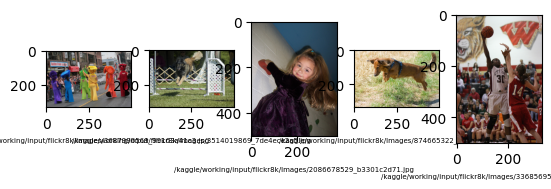

In [6]:
#Visualise both the images & text present in the dataset
i = 1
for img in all_imgs[0:5]:
  image = cv2.imread(img)
  plt.subplot(1,5,i)
  plt.tight_layout
  plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
  plt.xlabel(img, fontsize = 5)
  i += 1

text_file = f'{input_dir}/flickr8k/captions.txt'

In [7]:
#Import the dataset and read the text file into a seperate variable

def load_doc(filename):
    #your code here
    with open(filename, 'r') as text_in:
      text = list(filter(None, (line.rstrip() for line in text_in)))

    comma_text = []
    for line in text:
      comma_text.append(line.split(",", maxsplit = 1))
    return comma_text

doc = load_doc(text_file)
print(doc[:300])

[['image', 'caption'], ['1000268201_693b08cb0e.jpg', 'A child in a pink dress is climbing up a set of stairs in an entry way .'], ['1000268201_693b08cb0e.jpg', 'A girl going into a wooden building .'], ['1000268201_693b08cb0e.jpg', 'A little girl climbing into a wooden playhouse .'], ['1000268201_693b08cb0e.jpg', 'A little girl climbing the stairs to her playhouse .'], ['1000268201_693b08cb0e.jpg', 'A little girl in a pink dress going into a wooden cabin .'], ['1001773457_577c3a7d70.jpg', 'A black dog and a spotted dog are fighting'], ['1001773457_577c3a7d70.jpg', 'A black dog and a tri-colored dog playing with each other on the road .'], ['1001773457_577c3a7d70.jpg', 'A black dog and a white dog with brown spots are staring at each other in the street .'], ['1001773457_577c3a7d70.jpg', 'Two dogs of different breeds looking at each other on the road .'], ['1001773457_577c3a7d70.jpg', 'Two dogs on pavement moving toward each other .'], ['1002674143_1b742ab4b8.jpg', 'A little girl covere

Create a dataframe which summarizes the image, path & captions as a dataframe

Each image id has 5 captions associated with it therefore the total dataset should have 40455 samples.

In [8]:
all_img_id = [i[0] for i in doc[1:]] #store all the image id here
all_img_vector = [images + i[0] for i in doc[1:]] #store all the image path here
annotations = [i[1] for i in doc[1:]] #store all the captions here

df = pd.DataFrame(list(zip(all_img_id, all_img_vector,annotations)),columns =['ID','Path', 'Captions'])

df.head()

,ID,Path,Captions
0,1000268201_693b08cb0e.jpg,/kaggle/working/input/flickr8k/Images/10002682...,A child in a pink dress is climbing up a set o...
1,1000268201_693b08cb0e.jpg,/kaggle/working/input/flickr8k/Images/10002682...,A girl going into a wooden building .
2,1000268201_693b08cb0e.jpg,/kaggle/working/input/flickr8k/Images/10002682...,A little girl climbing into a wooden playhouse .
3,1000268201_693b08cb0e.jpg,/kaggle/working/input/flickr8k/Images/10002682...,A little girl climbing the stairs to her playh...
4,1000268201_693b08cb0e.jpg,/kaggle/working/input/flickr8k/Images/10002682...,A little girl in a pink dress going into a woo...


In [9]:
#Create a list which contains all the captions
annotations = [i for i in df['Captions']] #write your code here
print(f'Dataset Sample Captions: {annotations[:10]}\n', '*' * 10)

#add the <start> & <end> token to all those captions as well
annotations = ['<start> ' + i + ' <end>' for i in df['Captions']]
print(f'Captions post Start and End Tag annotations: {annotations[:10]}', '*' * 10)

#Create a list which contains all the path to the images
all_img_path = [i for i in df['Path']] #write your code here
print(f'Dataset Sample Image Paths: {all_img_path[:10]}','*' * 10)

print("Total captions present in the dataset: "+ str(len(annotations)))
print("Total images present in the dataset: " + str(len(all_img_path)))

Dataset Sample Captions: ['A child in a pink dress is climbing up a set of stairs in an entry way .', 'A girl going into a wooden building .', 'A little girl climbing into a wooden playhouse .', 'A little girl climbing the stairs to her playhouse .', 'A little girl in a pink dress going into a wooden cabin .', 'A black dog and a spotted dog are fighting', 'A black dog and a tri-colored dog playing with each other on the road .', 'A black dog and a white dog with brown spots are staring at each other in the street .', 'Two dogs of different breeds looking at each other on the road .', 'Two dogs on pavement moving toward each other .']
 **********
Captions post Start and End Tag annotations: ['<start> A child in a pink dress is climbing up a set of stairs in an entry way . <end>', '<start> A girl going into a wooden building . <end>', '<start> A little girl climbing into a wooden playhouse . <end>', '<start> A little girl climbing the stairs to her playhouse . <end>', '<start> A little g

In [10]:
#Create the vocabulary & the counter for the captions
vocabulary = [] #write your code here
for i in df['Captions']:
  for j in i.lower().split():
    vocabulary.append(j)

val_count=Counter(vocabulary)
val_count

Counter({'a': 61752,
         '.': 34212,
         'in': 18965,
         'the': 18249,
         'on': 10732,
         'is': 9345,
         'and': 8851,
         'dog': 8126,
         'with': 7761,
         'man': 7238,
         'of': 6712,
         'two': 5224,
         'white': 3935,
         'black': 3825,
         'boy': 3561,
         'are': 3504,
         'woman': 3385,
         'girl': 3320,
         ',': 3210,
         'to': 3173,
         'wearing': 3061,
         'at': 2905,
         'people': 2856,
         'water': 2779,
         'red': 2672,
         'young': 2607,
         'brown': 2549,
         'an': 2399,
         '."': 2365,
         'his': 2357,
         'blue': 2266,
         'dogs': 2122,
         'running': 2073,
         'through': 2031,
         'playing': 2008,
         'while': 1957,
         'down': 1824,
         'shirt': 1803,
         'standing': 1786,
         'ball': 1778,
         'little': 1754,
         'grass': 1621,
         'person': 1536,
         

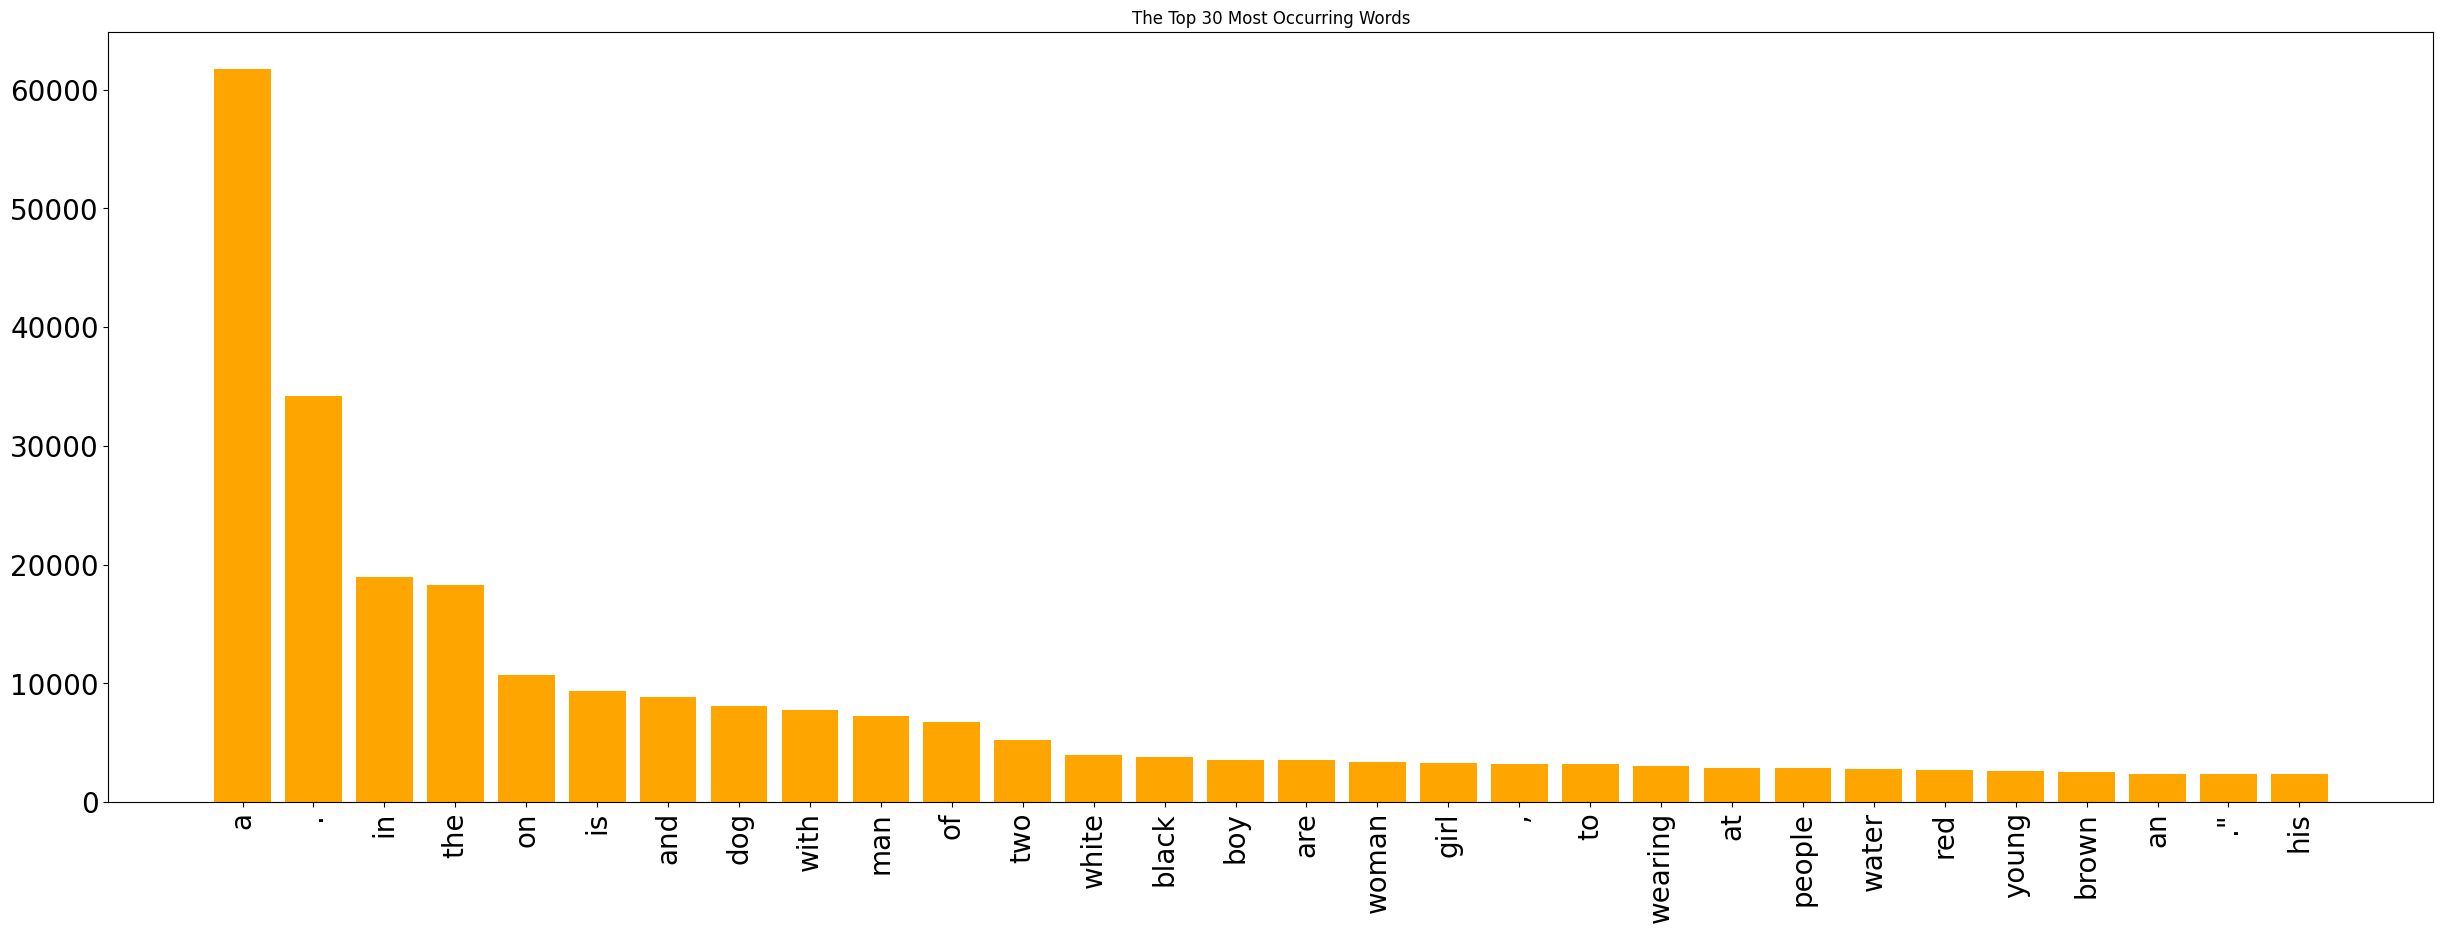

In [11]:
#Visualise the top 30 occuring words in the captions

#write your code here
sorted_tuples = sorted(val_count.items(), key = lambda x: x[1], reverse = True)
sorted_dict = {k:v for k,v in sorted_tuples}
val_count.most_common(30)
top_30 = dict(val_count.most_common(30))

plt.figure(figsize = (30,10))
plt.title("The Top 30 Most Occurring Words")
plt.bar(range(len(top_30)), list(top_30.values()), align = 'center', color = 'orange')
plt.xticks(range(len(top_30)), list(top_30.keys()), fontsize = 20, rotation = 90, color = 'black')
plt.yticks(fontsize = 20, color = 'black')

plt.show()

## Pre-Processing the captions
1.Create the tokenized vectors by tokenizing the captions fore ex :split them using spaces & other filters.
This gives us a vocabulary of all of the unique words in the data. Keep the total vocaublary to top 5,000 words for saving memory.

2.Replace all other words with the unknown token "UNK" .

3.Create word-to-index and index-to-word mappings.

4.Pad all sequences to be the same length as the longest one.

In [12]:
# create the tokenizer

#your code here
top_k = 5000
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=top_k,
                                                  oov_token="<unk>",
                                                  filters='!"#$%&()*+.,-/:;=?@[\]^_`{|}~ ')
tokenizer.fit_on_texts(annotations)

In [13]:
# Create word-to-index and index-to-word mappings.

#your code here
word_index = tokenizer.word_index
index_word = tokenizer.index_word
train_sequences = tokenizer.texts_to_sequences(annotations)

tokenizer.word_index['<pad>'] = 0
tokenizer.index_word[0] = '<pad>'

print('Word to Index:\n', word_index, '\n','='*100)
print('Index to Word:\n', index_word, '\n','='*100)

print('For Caption: \n', annotations[1], '\n','='*100)
print('The train sequence is: \n', train_sequences[1], '\n','='*100)

Word to Index:
 {'<unk>': 1, 'a': 2, '<start>': 3, '<end>': 4, 'in': 5, 'the': 6, 'on': 7, 'is': 8, 'and': 9, 'dog': 10, 'with': 11, 'man': 12, 'of': 13, 'two': 14, 'white': 15, 'black': 16, 'boy': 17, 'are': 18, 'woman': 19, 'girl': 20, 'to': 21, 'wearing': 22, 'at': 23, 'people': 24, 'water': 25, 'red': 26, 'young': 27, 'brown': 28, 'an': 29, 'his': 30, 'blue': 31, 'dogs': 32, 'running': 33, 'through': 34, 'playing': 35, 'while': 36, 'shirt': 37, 'down': 38, 'standing': 39, 'ball': 40, 'little': 41, 'grass': 42, 'snow': 43, 'child': 44, 'person': 45, 'jumping': 46, 'over': 47, 'three': 48, 'front': 49, 'sitting': 50, 'holding': 51, 'up': 52, 'field': 53, 'small': 54, 'by': 55, 'large': 56, 'green': 57, 'one': 58, 'group': 59, 'yellow': 60, 'her': 61, 'walking': 62, 'children': 63, 'men': 64, 'into': 65, 'air': 66, 'beach': 67, 'near': 68, 'mouth': 69, 'jumps': 70, 'another': 71, 'for': 72, 'street': 73, 'runs': 74, 'its': 75, 'from': 76, 'riding': 77, 'stands': 78, 'as': 79, 'bike': 

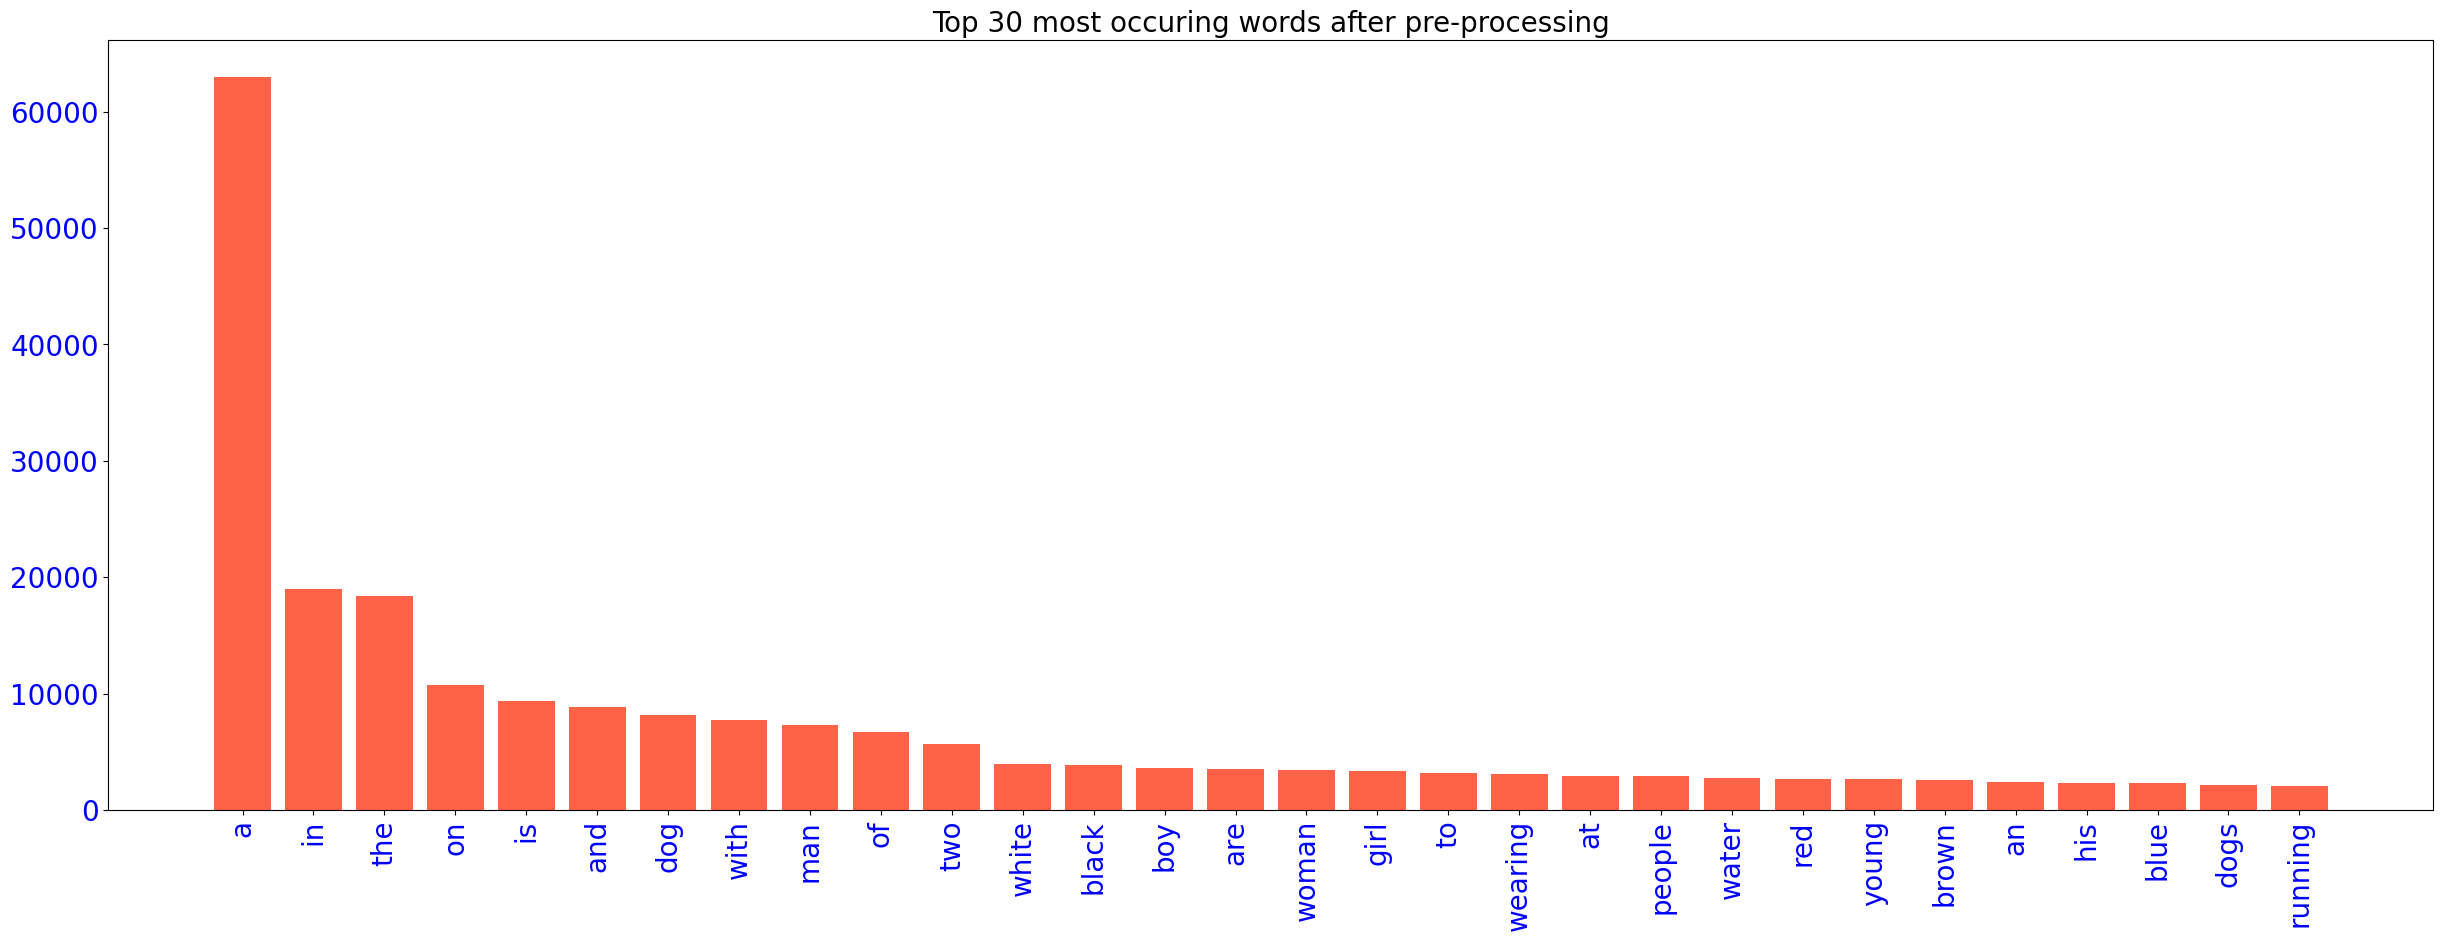

In [14]:
# Create a word count of your tokenizer to visulize the Top 30 occuring words after text processing

#your code here
from matplotlib import cm

from collections import Counter
wordcount = tokenizer.word_counts

sorted_tuples = sorted(wordcount.items(), key=lambda item: item[1], reverse=True)

sorted_count = Counter({k: v for k, v in sorted_tuples if k != '<start>' and k !='<end>'})

top_words = dict(sorted_count.most_common(30))

plt.figure(figsize=(30,10))

plt.bar(range(len(top_words)), list(top_words.values()), align='center', color = 'tomato')
plt.xticks(range(len(top_words)), list(top_words.keys()),rotation=90, fontsize=20,color = 'blue')
plt.yticks(fontsize=20,color ='blue')
plt.title("Top 30 most occuring words after pre-processing",fontsize=20)

plt.show()

In [15]:
# Pad each vector to the max_length of the captions ^ store it to a vairable

maxlen = max([len(x) for x in train_sequences])
print("maximum length:\n", maxlen)

cap_vector = tf.keras.preprocessing.sequence.pad_sequences(train_sequences, padding='post') #your code here

print("\nTraining sequences data type:\n", type(train_sequences),'\n','='*100)
print("\nPadded training shape:\n", cap_vector.shape,'\n','='*100)
print("\nTraining sequences:\n", train_sequences,'\n','='*100)

print("\nPadded Training sequences data type:\n", type(cap_vector),'\n','='*100)

print("The shape of Caption vector is :" + str(cap_vector.shape))

print("\nPadded training sequences:\n", cap_vector,'\n','='*100)

maximum length:
 39

Training sequences data type:
 <class 'list'> 

Padded training shape:
 (40455, 39) 

Training sequences:
 [[3, 2, 44, 5, 2, 91, 173, 8, 120, 52, 2, 394, 13, 395, 5, 29, 1, 671, 4], [3, 2, 20, 317, 65, 2, 197, 118, 4], [3, 2, 41, 20, 120, 65, 2, 197, 2438, 4], [3, 2, 41, 20, 120, 6, 395, 21, 61, 2438, 4], [3, 2, 41, 20, 5, 2, 91, 173, 317, 65, 2, 197, 2982, 4], [3, 2, 16, 10, 9, 2, 844, 10, 18, 344, 4], [3, 2, 16, 10, 9, 2, 1576, 236, 10, 35, 11, 138, 83, 7, 6, 152, 4], [3, 2, 16, 10, 9, 2, 15, 10, 11, 28, 1002, 18, 641, 23, 138, 83, 5, 6, 73, 4], [3, 14, 32, 13, 742, 2654, 90, 23, 138, 83, 7, 6, 152, 4], [3, 14, 32, 7, 728, 806, 322, 138, 83, 4], [3, 2, 41, 20, 165, 5, 607, 107, 5, 49, 13, 2, 595, 1194, 11, 61, 221, 5, 2, 977, 4], [3, 2, 41, 20, 8, 50, 5, 49, 13, 2, 56, 595, 1194, 4], [3, 2, 54, 20, 5, 6, 42, 115, 11, 3422, 5, 49, 13, 2, 15, 2439, 11, 2, 1194, 7, 150, 4], [3, 190, 8, 2, 20, 11, 1577, 50, 5, 49, 13, 2, 1194, 773, 4], [3, 27, 20, 11, 1577, 773, 82, 

## Pre-processing the images

1.Resize them into the shape of (299, 299)

3.Normalize the image within the range of -1 to 1, such that it is in correct format for InceptionV3.

### FAQs on how to resize the images::
* Since you have a list which contains all the image path, you need to first convert them to a dataset using <i>tf.data.Dataset.from_tensor_slices</i>. Once you have created a dataset consisting of image paths, you need to apply a function to the dataset which will apply the necessary preprocessing to each image.
* This function should resize them and also should do the necessary preprocessing that it is in correct format for InceptionV3.


In [16]:
#write your code here for creating the function. This function should return images & their path

def load_image(image_path):
    #write your pre-processing steps here
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, (299, 299)) #Resize to (299,299)
    img = tf.keras.applications.inception_v3.preprocess_input(img) #Normalize images
    return img, image_path

In [17]:
#write your code here to create the dataset consisting of image paths

# Get unique images
encode_train = sorted(set(all_img_path))

image_dataset = tf.data.Dataset.from_tensor_slices(encode_train)

In [18]:
#write your code here for applying the function to the image path dataset, such that the transformed dataset should contain images & their path

#Images will be resized to (299,299,3) and will be normalized.
image_dataset = image_dataset.map(
  load_image, num_parallel_calls=tf.data.AUTOTUNE).batch(64)

# print the resized image dataset.
image_dataset

<_BatchDataset element_spec=(TensorSpec(shape=(None, 299, 299, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None))>

## Load the pretrained Imagenet weights of Inception net V3

1.To save the memory(RAM) from getting exhausted, extract the features of the images using the last layer of pre-trained model. Including this as part of training will lead to higher computational time.

2.The shape of the output of this layer is 8x8x2048.

3.Use a function to extract the features of each image in the train & test dataset such that the shape of each image should be (batch_size, 8*8, 2048)



In [19]:
image_model = tf.keras.applications.InceptionV3(include_top=False,weights='imagenet')

new_input = image_model.input #write code here to get the input of the image_model
hidden_layer = image_model.layers[-1].output #write code here to get the output of the image_model

image_features_extract_model = tf.keras.Model(new_input, hidden_layer) #build the final model using both input & output layer

image_features_extract_model.summary()

87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, None,      │          0 │ -                 │
│ (InputLayer)        │ None, 3)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, None,      │        864 │ input_layer[0][0] │
│                     │ None, 32)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, None,      │         96 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ None, 32)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, None,      │          0 │ batch_normalizat… │
│ (Activation)        │ None, 32)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, None,      │      9,216 │ activation[0][0]  │
│                     │ None, 32)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, None,      │         96 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ None, 32)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, None,      │          0 │ batch_normalizat… │
│ (Activation)        │ None, 32)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, None,      │     18,432 │ activation_1[0][… │
│                     │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, None,      │        192 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, None,      │          0 │ batch_normalizat… │
│ (Activation)        │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, None,      │          0 │ activation_2[0][… │
│ (MaxPooling2D)      │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, None,      │      5,120 │ max_pooling2d[0]… │
│                     │ None, 80)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, None,      │        240 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ None, 80)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, None,      │          0 │ batch_normalizat… │
│ (Activation)        │ None, 80)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, None,      │    138,240 │ activation_3[0][… │
│                     │ None, 192)        │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, None,      │        576 │ conv2d_4[0][0]    │
│ (BatchNormalizatio… │ None, 192)        │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_4        │ (None, None,      │          0 │ batch_normalizat

 Total params: 21,802,784 (83.17 MB)

 Trainable params: 21,768,352 (83.04 MB)

 Non-trainable params: 34,432 (134.50 KB)

In [20]:
# write the code to apply the feature_extraction model to your earlier created dataset which contained images & their respective paths
# Once the features are created, you need to reshape them such that feature shape is in order of (batch_size, 8*8, 2048)
from tqdm import tqdm

#Save image features to .npy files
for img, path in tqdm(image_dataset):
  batch_features = image_features_extract_model(img)
  batch_features = tf.reshape(batch_features,
                              (batch_features.shape[0], -1, batch_features.shape[3]))

  for bf, p in zip(batch_features, path):
    path_of_feature = p.numpy().decode("utf-8")
    np.save(path_of_feature, bf.numpy())

100%|██████████| 127/127 [01:03<00:00,  2.00it/s]


### FAQs on how to store the features:
* You can store the features using a dictionary with the path as the key and values as the feature extracted by the inception net v3 model OR
* You can store using numpy(np.save) to store the resulting vector.

## Dataset creation
1.Apply train_test_split on both image path & captions to create the train & test list. Create the train-test spliit using 80-20 ratio & random state = 42

2.Create a function which maps the image path to their feature.

3.Create a builder function to create train & test dataset & apply the function created earlier to transform the dataset

2.Make sure you have done Shuffle and batch while building the dataset

3.The shape of each image in the dataset after building should be (batch_size, 8*8, 2048)

4.The shape of each caption in the dataset after building should be(batch_size, max_len)


In [21]:
#write your code here
from sklearn.utils import shuffle

# Shuffle captions and image_names together
all_img_path, cap_vector = shuffle(all_img_path,cap_vector,random_state=1)

#your code goes here
path_train, path_test, cap_train, cap_test = train_test_split(all_img_path, cap_vector, test_size = 0.2, random_state = 42)

In [22]:
print("Training data for images: " + str(len(path_train)))
print("Testing data for images: " + str(len(path_test)))
print("Training data for Captions: " + str(len(cap_train)))
print("Testing data for Captions: " + str(len(cap_test)))

Training data for images: 32364
Testing data for images: 8091
Training data for Captions: 32364
Testing data for Captions: 8091


In [23]:
# Create a function which maps the image path to their feature.
# This function will take the image_path & caption and return it's feature & respective caption.

def map_func(img_name, cap): # your input variable goes here):
  img_tensor = np.load(img_name.decode('utf-8') + '.npy') # write your code here to extract the features from the dictionary stored earlier
  return img_tensor, cap

### FAQs on how to load the features:
* You can load the features using the dictionary created earlier OR
* You can store using numpy(np.load) to load the feature vector.

In [24]:
#tf.config.run_functions_eagerly(True)

In [25]:
# create a builder function to create dataset which takes in the image path & captions as input
# This function should transform the created dataset(img_path,cap) to (features,cap) using the map_func created earlier

BATCH_SIZE = 64
BUFFER_SIZE = 2000

def gen_dataset(img_data, cap_data): #your input variables):

    # your code goes here to create the dataset & transform it
    dataset = tf.data.Dataset.from_tensor_slices((img_data, cap_data))

    # Use map to load the numpy files in parallel
    dataset = dataset.map(lambda item1, item2: tf.numpy_function(
          map_func, [item1, item2], [tf.float32, tf.int32]),
          num_parallel_calls=tf.data.experimental.AUTOTUNE)

    # Shuffle and batch
    dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
    dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

    return dataset

In [26]:
train_dataset=gen_dataset(path_train,cap_train)
test_dataset=gen_dataset(path_test,cap_test)

In [27]:
train_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=<unknown>, dtype=tf.float32, name=None), TensorSpec(shape=<unknown>, dtype=tf.int32, name=None))>

In [28]:
# sample_img_batch, sample_cap_batch = next(iter(train_dataset))
sample_img_batch, sample_cap_batch = next(iter(train_dataset))
print(sample_img_batch.shape)  #(batch_size, 8*8, 2048)
print(sample_cap_batch.shape) #(batch_size,max_len)

(64, 64, 2048)
(64, 39)


## Model Building
1.Set the parameters

2.Build the Encoder, Attention model & Decoder

In [29]:
embedding_dim = 256
units = 512
vocab_size = top_k + 1 #top 5,000 words +1
train_num_steps = len(path_train) // BATCH_SIZE #len(total train images) // BATCH_SIZE
test_num_steps = len(path_test) // BATCH_SIZE #len(total test images) // BATCH_SIZE

features_shape = bf.shape[1]
attention_features_shape = bf.shape[0]

### Encoder

In [30]:
class Encoder(tf.keras.Model):
    def __init__(self,embed_dim):
        super(Encoder, self).__init__()
        self.dense = tf.keras.layers.Dense(embedding_dim, activation = 'relu') #build your Dense layer with relu activation

    def call(self, features):
        features = self.dense(features) # extract the features from the image shape: (batch, 8*8, embed_dim)
        return features

In [31]:
encoder=Encoder(embedding_dim)

### Attention model

In [32]:
class Attention_model(tf.keras.Model):
    def __init__(self, units):
        super(Attention_model, self).__init__()
        self.W1 = tf.keras.layers.Dense(units) #build your Dense layer
        self.W2 = tf.keras.layers.Dense(units) #build your Dense layer
        self.V = tf.keras.layers.Dense(1) #build your final Dense layer with unit 1
        self.units=units

    def call(self, features, hidden):
        #features shape: (batch_size, 8*8, embedding_dim)
        # hidden shape: (batch_size, hidden_size)

        # Expand the hidden shape to shape: (batch_size, 1, hidden_size)
        hidden_with_time_axis =  tf.expand_dims(hidden, 1)

        # build your score funciton to shape: (batch_size, 8*8, units)
        score = self.V(tf.nn.tanh(self.W1(features) + self.W2(hidden_with_time_axis)))

        # extract your attention weights with shape: (batch_size, 8*8, 1)
        attention_weights = tf.nn.softmax(score, axis=1)

        #shape: create the context vector with shape (batch_size, 8*8,embedding_dim)
        context_vector = attention_weights * features

        # reduce the shape to (batch_size, embedding_dim)
        context_vector = tf.reduce_sum(context_vector, axis=1)


        return context_vector, attention_weights

### Decoder

In [33]:
class Decoder(tf.keras.Model):
    def __init__(self, embed_dim, units, vocab_size):
        super(Decoder, self).__init__()
        self.units=units

        #iniitalise your Attention model with units
        self.attention = Attention_model(self.units)

        #build your Embedding layer
        self.embed = tf.keras.layers.Embedding(vocab_size, embedding_dim)

        self.gru = keras.layers.RNN(keras.layers.GRUCell(units, recurrent_initializer='glorot_uniform'),return_sequences=True,return_state=True,)

        #build your Dense layer
        self.d1 = tf.keras.layers.Dense(self.units)

        #build your Dense layer
        self.d2 = tf.keras.layers.Dense(vocab_size)


    def call(self,x,features, hidden):

        #create your context vector & attention weights from attention model
        context_vector, attention_weights = self.attention(features, hidden)

        # embed your input to shape: (batch_size, 1, embedding_dim)
        embed = self.embed(x)

        # Concatenate your input with the context vector from attention layer. Shape: (batch_size, 1, embedding_dim + embedding_dim)
        embed =  tf.concat([tf.expand_dims(context_vector, 1), embed], axis=-1)

        # Extract the output & hidden state from GRU layer. Output shape : (batch_size, max_length, hidden_size)
        output,state = self.gru(embed)
        output = self.d1(output)
        output = tf.reshape(output, (-1, output.shape[2])) # shape : (batch_size * max_length, hidden_size)
        output = self.d2(output) # shape : (batch_size * max_length, vocab_size)

        return output,state,attention_weights

    def init_state(self, batch_size):
        return tf.zeros((batch_size, self.units))

In [34]:
decoder=Decoder(embedding_dim, units, vocab_size)

In [35]:
features=encoder(sample_img_batch)

hidden = decoder.init_state(batch_size=sample_cap_batch.shape[0])
dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * sample_cap_batch.shape[0], 1)

predictions, hidden_out, attention_weights= decoder(dec_input, features, hidden)
print('Feature shape from Encoder: {}'.format(features.shape)) #(batch, 8*8, embed_dim)
print('Predcitions shape from Decoder: {}'.format(predictions.shape)) #(batch,vocab_size)
print('Attention weights shape from Decoder: {}'.format(attention_weights.shape)) #(batch, 8*8, embed_dim)

Feature shape from Encoder: (64, 64, 256)
Predcitions shape from Decoder: (64, 5001)
Attention weights shape from Decoder: (64, 64, 1)


## Model training & optimization
1.Set the optimizer & loss object

2.Create your checkpoint path

3.Create your training & testing step functions

4.Create your loss function for the test dataset

Numerous train and test runs have been performed with different combinations of various parameters and hyperparameters, such as:

Batch Size (32, 64, 128, 256)
Optimizer (Such as: Adam, RMSprop, Adagrad etc.)
Number of Epochs (5, 10, 20, 30, 50)
Learning Rate (0.01, 0.001, 0.0005)
Embedding Dimension
Buffer (1000, 2000)
Units (512)
Evaluation done based on the below:

Train and Test Loss
BLEU Score

Finally, I arrived at the below combination which gave me balanced result:

**Batch Size = 64**

Justification: There was a better Train loss observed than with the 32 size. Batch size didn't show much improvement, and with 256 was getting memory error. Hence, Batch Size 64 selected.

**Optimizer = RMSprop**

Justification: A train loss of 0.20 could be achieved with Adam(), but, test_step() loss was increasing steeply and reached 4+, whereas, with RMSprop (momentum = 0.001, learning_rate = 0.0005) test_step loss stabilized to approx. 2.5.

**Number of Epochs = 50**

Justification: With Adam() and Learning rate 0.001, it was easily achieving train loss 0.3 in 20 epochs. However, test loss was increasing rapidly (reached 3+ in 20 epochs, and then 4+ in 50 epochs). Also Adam() gave a train loss of 0.227 in 50 epochs. But if we compare with RMSprop (Learning rate =0.0005, momentum = 0.001) it achieved train loss = 0.378, and test loss saturated to approx. 2.5. So as RMSprop look more balanced, and to achieve the desired accuracy, 50 epochs have been chosen.

Learning Rate (0.01, 0.001, 0.0005) = As explained above.
Embedding Dimension = 256
Buffer = 2000
Units = 512

In [36]:
optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.0005,momentum=0.001) #define the optimizer
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none') #define your loss object

In [37]:
def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)

    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask

    return tf.reduce_mean(loss_)

In [38]:
# Copy previous checkpoint from input if running on Kaggle
if os.path.exists(f'{input_dir}/DheerajM_Eye_For_The_Blind/checkpoints'):
    !cp -rf "{input_dir}/DheerajM_Eye_For_The_Blind/checkpoints" "{checkpoint_dir}"
    
ckpt = tf.train.Checkpoint(encoder=encoder,
                           decoder=decoder,
                           optimizer = optimizer)
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

In [39]:
start_epoch = 0
if ckpt_manager.latest_checkpoint:
    start_epoch = int(ckpt_manager.latest_checkpoint.split('-')[-1])

* While creating the training step for your model, you will apply Teacher forcing.
* Teacher forcing is a technique where the target/real word is passed as the next input to the decoder instead of previous prediciton.

In [40]:
@tf.function
def train_step(img_tensor, target):
    loss = 0
    hidden = decoder.init_state(batch_size=target.shape[0])
    dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * target.shape[0], 1)

    with tf.GradientTape() as tape:
        #write your code here to do the training steps
        features = encoder(img_tensor)

        for i in range(1, target.shape[1]):
            # Predict using decoder
            predictions, hidden, _ = decoder(dec_input, features, hidden)

            loss += loss_function(target[:, i], predictions) # loss of a batch at i-th token

            # Teacher forcing, use token from target instead of prediction
            dec_input = tf.expand_dims(target[:, i], 1)

    avg_loss = loss / int(target.shape[1]) # Average loss over max length, include padding
    trainable_variables = encoder.trainable_variables + decoder.trainable_variables
    gradients = tape.gradient(loss, trainable_variables)

#     for grad, var in zip(gradients, trainable_variables):
#        print(f"Gradient shape: {grad.shape}, Variable shape: {var.shape}")

    optimizer.apply_gradients(zip(gradients, trainable_variables))

    return loss, avg_loss

* While creating the test step for your model, you will pass your previous prediciton as the next input to the decoder.

In [41]:
@tf.function
def test_step(img_tensor, target):
    loss = 0

    #write your code here to do the testing steps
    hidden = decoder.init_state(batch_size=target.shape[0])
    dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * target.shape[0], 1)

    features = encoder(img_tensor)

    for i in range(1, target.shape[1]):
        # Predict using decoder
        predictions, hidden, _ = decoder(dec_input, features, hidden)

        loss += loss_function(target[:, i], predictions) # loss of a batch at i-th token

        predicted_token_id =  tf.argmax(predictions,1) # Batch of predicted tokens
        dec_input = tf.expand_dims(predicted_token_id, 1)

    avg_loss = loss / int(target.shape[1]) # Average loss over max length, include padding

    return loss, avg_loss

In [42]:
def test_loss_cal(test_dataset):
    total_loss = 0

    #write your code to get the average loss result on your test data
    for batch, (img_tensor, target) in enumerate(test_dataset):
        _, batch_loss_avg = test_step(img_tensor, target)
        total_loss += batch_loss_avg

    avg_test_loss = total_loss / len(test_dataset)

    return avg_test_loss

In [43]:
# tf.config.run_functions_eagerly(True)

In [44]:
loss_plot = []
test_loss_plot = []
EPOCHS = 50

best_test_loss=100
for epoch in tqdm(range(0, EPOCHS)):
    start = time.time()
    total_loss = 0

    for (batch, (img_tensor, target)) in enumerate(train_dataset):
        batch_loss, t_loss = train_step(img_tensor, target)
        total_loss += t_loss
        avg_train_loss=total_loss / train_num_steps

    loss_plot.append(avg_train_loss)
    test_loss = test_loss_cal(test_dataset)
    test_loss_plot.append(test_loss)

    print ('For epoch: {}, the train loss is {:.3f}, & test loss is {:.3f}'.format(epoch+1,avg_train_loss,test_loss))
    print ('Time taken for 1 epoch {} sec\n'.format(time.time() - start))

    if test_loss < best_test_loss:
        print('Test loss has been reduced from %.3f to %.3f' % (best_test_loss, test_loss))
        best_test_loss = test_loss
        ckpt_manager.save()

  0%|          | 0/50 [00:00<?, ?it/s]

For epoch: 1, the train loss is 1.337, & test loss is 1.868
Time taken for 1 epoch 206.7320032119751 sec

Test loss has been reduced from 100.000 to 1.868


  2%|▏         | 1/50 [03:27<2:49:03, 207.01s/it]

For epoch: 2, the train loss is 1.091, & test loss is 1.777
Time taken for 1 epoch 113.47355675697327 sec

Test loss has been reduced from 1.868 to 1.777


  6%|▌         | 3/50 [07:11<1:44:20, 133.21s/it]

For epoch: 3, the train loss is 1.019, & test loss is 1.814
Time taken for 1 epoch 110.69785642623901 sec



  8%|▊         | 4/50 [09:04<1:36:04, 125.31s/it]

For epoch: 4, the train loss is 0.973, & test loss is 1.791
Time taken for 1 epoch 113.19082069396973 sec



 10%|█         | 5/50 [10:56<1:30:21, 120.48s/it]

For epoch: 5, the train loss is 0.937, & test loss is 1.875
Time taken for 1 epoch 111.91891694068909 sec



 12%|█▏        | 6/50 [12:46<1:25:44, 116.92s/it]

For epoch: 6, the train loss is 0.906, & test loss is 1.806
Time taken for 1 epoch 110.0193452835083 sec



 14%|█▍        | 7/50 [14:37<1:22:18, 114.85s/it]

For epoch: 7, the train loss is 0.878, & test loss is 1.869
Time taken for 1 epoch 110.56395530700684 sec



 16%|█▌        | 8/50 [16:30<1:20:00, 114.31s/it]

For epoch: 8, the train loss is 0.853, & test loss is 1.820
Time taken for 1 epoch 113.14891862869263 sec



 18%|█▊        | 9/50 [18:20<1:17:16, 113.08s/it]

For epoch: 9, the train loss is 0.830, & test loss is 1.866
Time taken for 1 epoch 110.37671136856079 sec



 20%|██        | 10/50 [20:11<1:14:50, 112.26s/it]

For epoch: 10, the train loss is 0.808, & test loss is 1.908
Time taken for 1 epoch 110.42041993141174 sec



 22%|██▏       | 11/50 [22:01<1:12:40, 111.80s/it]

For epoch: 11, the train loss is 0.787, & test loss is 1.887
Time taken for 1 epoch 110.75364899635315 sec



 24%|██▍       | 12/50 [23:52<1:10:32, 111.39s/it]

For epoch: 12, the train loss is 0.767, & test loss is 1.943
Time taken for 1 epoch 110.4623212814331 sec



 26%|██▌       | 13/50 [25:42<1:08:29, 111.06s/it]

For epoch: 13, the train loss is 0.748, & test loss is 1.900
Time taken for 1 epoch 110.31076788902283 sec



 28%|██▊       | 14/50 [27:32<1:06:25, 110.70s/it]

For epoch: 14, the train loss is 0.729, & test loss is 1.946
Time taken for 1 epoch 109.86577653884888 sec



 30%|███       | 15/50 [29:22<1:04:30, 110.60s/it]

For epoch: 15, the train loss is 0.712, & test loss is 1.988
Time taken for 1 epoch 110.34462690353394 sec



 32%|███▏      | 16/50 [31:13<1:02:36, 110.48s/it]

For epoch: 16, the train loss is 0.695, & test loss is 1.965
Time taken for 1 epoch 110.21525025367737 sec



 34%|███▍      | 17/50 [33:03<1:00:47, 110.53s/it]

For epoch: 17, the train loss is 0.679, & test loss is 1.982
Time taken for 1 epoch 110.65309882164001 sec



 36%|███▌      | 18/50 [34:53<58:52, 110.40s/it]  

For epoch: 18, the train loss is 0.662, & test loss is 2.081
Time taken for 1 epoch 110.07876491546631 sec



 38%|███▊      | 19/50 [36:45<57:10, 110.66s/it]

For epoch: 19, the train loss is 0.647, & test loss is 2.064
Time taken for 1 epoch 111.28205728530884 sec



 40%|████      | 20/50 [38:38<55:42, 111.42s/it]

For epoch: 20, the train loss is 0.633, & test loss is 2.112
Time taken for 1 epoch 113.18727016448975 sec



 42%|████▏     | 21/50 [40:28<53:41, 111.07s/it]

For epoch: 21, the train loss is 0.619, & test loss is 2.115
Time taken for 1 epoch 110.2606348991394 sec



 44%|████▍     | 22/50 [42:19<51:51, 111.11s/it]

For epoch: 22, the train loss is 0.606, & test loss is 2.232
Time taken for 1 epoch 111.18452000617981 sec



 46%|████▌     | 23/50 [44:09<49:52, 110.83s/it]

For epoch: 23, the train loss is 0.592, & test loss is 2.241
Time taken for 1 epoch 110.19743084907532 sec



 48%|████▊     | 24/50 [46:00<47:57, 110.65s/it]

For epoch: 24, the train loss is 0.581, & test loss is 2.213
Time taken for 1 epoch 110.23379015922546 sec



 50%|█████     | 25/50 [47:50<46:02, 110.50s/it]

For epoch: 25, the train loss is 0.568, & test loss is 2.232
Time taken for 1 epoch 110.13743734359741 sec



 52%|█████▏    | 26/50 [49:40<44:06, 110.28s/it]

For epoch: 26, the train loss is 0.556, & test loss is 2.246
Time taken for 1 epoch 109.7670328617096 sec



 54%|█████▍    | 27/50 [51:30<42:17, 110.34s/it]

For epoch: 27, the train loss is 0.545, & test loss is 2.297
Time taken for 1 epoch 110.46912956237793 sec



 56%|█████▌    | 28/50 [53:22<40:36, 110.73s/it]

For epoch: 28, the train loss is 0.534, & test loss is 2.337
Time taken for 1 epoch 111.64595413208008 sec



 58%|█████▊    | 29/50 [55:12<38:41, 110.55s/it]

For epoch: 29, the train loss is 0.525, & test loss is 2.323
Time taken for 1 epoch 110.11540460586548 sec



 60%|██████    | 30/50 [57:05<37:06, 111.30s/it]

For epoch: 30, the train loss is 0.514, & test loss is 2.351
Time taken for 1 epoch 113.06338143348694 sec



 62%|██████▏   | 31/50 [58:55<35:08, 110.98s/it]

For epoch: 31, the train loss is 0.504, & test loss is 2.357
Time taken for 1 epoch 110.21146988868713 sec



 64%|██████▍   | 32/50 [1:00:45<33:12, 110.70s/it]

For epoch: 32, the train loss is 0.495, & test loss is 2.420
Time taken for 1 epoch 110.0409893989563 sec



 66%|██████▌   | 33/50 [1:02:35<31:19, 110.57s/it]

For epoch: 33, the train loss is 0.485, & test loss is 2.463
Time taken for 1 epoch 110.26380777359009 sec



 68%|██████▊   | 34/50 [1:04:27<29:32, 110.75s/it]

For epoch: 34, the train loss is 0.476, & test loss is 2.422
Time taken for 1 epoch 111.18468689918518 sec



 70%|███████   | 35/50 [1:06:17<27:39, 110.65s/it]

For epoch: 35, the train loss is 0.468, & test loss is 2.409
Time taken for 1 epoch 110.3917076587677 sec



 72%|███████▏  | 36/50 [1:08:07<25:46, 110.47s/it]

For epoch: 36, the train loss is 0.459, & test loss is 2.442
Time taken for 1 epoch 110.07247805595398 sec



 74%|███████▍  | 37/50 [1:09:57<23:55, 110.41s/it]

For epoch: 37, the train loss is 0.451, & test loss is 2.471
Time taken for 1 epoch 110.24533987045288 sec



 76%|███████▌  | 38/50 [1:11:50<22:13, 111.09s/it]

For epoch: 38, the train loss is 0.443, & test loss is 2.469
Time taken for 1 epoch 112.68434023857117 sec



 78%|███████▊  | 39/50 [1:13:40<20:19, 110.85s/it]

For epoch: 39, the train loss is 0.435, & test loss is 2.420
Time taken for 1 epoch 110.27517437934875 sec



 80%|████████  | 40/50 [1:15:33<18:33, 111.39s/it]

For epoch: 40, the train loss is 0.428, & test loss is 2.454
Time taken for 1 epoch 112.66742134094238 sec



 82%|████████▏ | 41/50 [1:17:23<16:39, 111.03s/it]

For epoch: 41, the train loss is 0.420, & test loss is 2.474
Time taken for 1 epoch 110.19786143302917 sec



 84%|████████▍ | 42/50 [1:19:14<14:48, 111.07s/it]

For epoch: 42, the train loss is 0.414, & test loss is 2.473
Time taken for 1 epoch 111.1433117389679 sec



 86%|████████▌ | 43/50 [1:21:07<13:01, 111.58s/it]

For epoch: 43, the train loss is 0.407, & test loss is 2.458
Time taken for 1 epoch 112.76601123809814 sec



 88%|████████▊ | 44/50 [1:22:57<11:05, 110.98s/it]

For epoch: 44, the train loss is 0.399, & test loss is 2.529
Time taken for 1 epoch 109.57202959060669 sec



 90%|█████████ | 45/50 [1:24:46<09:13, 110.63s/it]

For epoch: 45, the train loss is 0.393, & test loss is 2.473
Time taken for 1 epoch 109.81928205490112 sec



 92%|█████████▏| 46/50 [1:26:36<07:21, 110.46s/it]

For epoch: 46, the train loss is 0.387, & test loss is 2.524
Time taken for 1 epoch 110.04838824272156 sec



 94%|█████████▍| 47/50 [1:28:27<05:31, 110.35s/it]

For epoch: 47, the train loss is 0.380, & test loss is 2.526
Time taken for 1 epoch 110.11507821083069 sec



 96%|█████████▌| 48/50 [1:30:19<03:41, 110.97s/it]

For epoch: 48, the train loss is 0.374, & test loss is 2.543
Time taken for 1 epoch 112.38928866386414 sec



 98%|█████████▊| 49/50 [1:32:09<01:50, 110.71s/it]

For epoch: 49, the train loss is 0.368, & test loss is 2.574
Time taken for 1 epoch 110.10659694671631 sec



100%|██████████| 50/50 [1:33:59<00:00, 112.78s/it]

For epoch: 50, the train loss is 0.362, & test loss is 2.580
Time taken for 1 epoch 109.68108177185059 sec



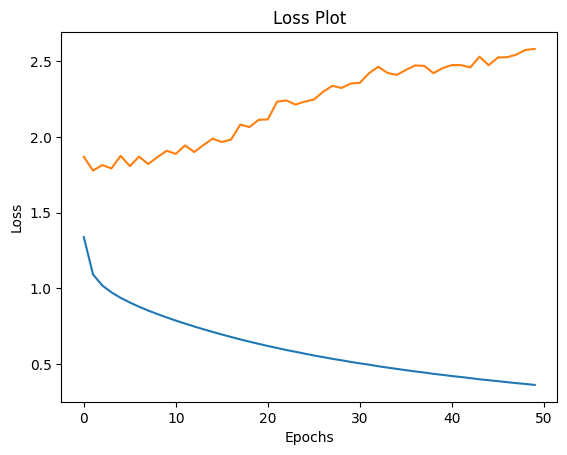

In [45]:
plt.plot(loss_plot)
plt.plot(test_loss_plot)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Plot')
plt.show()

#### NOTE:
* Since there is a difference between the train & test steps ( Presence of teacher forcing), you may observe that the train loss is decreasing while your test loss is not.
* This doesn't mean that the model is overfitting, as we can't compare the train & test results here, as both approach is different.
* Also, if you want to achieve better results you can run it more epochs, but the intent of this capstone is to give you an idea on how to integrate attention mechanism with E-D architecture for images. The intent is not to create the state of art model.

## Model Evaluation
1.Define your evaluation function using greedy search

2.Define your evaluation function using beam search ( optional)

3.Test it on a sample data using BLEU score

### Greedy Search

In [46]:
cap_vector

array([[   3,  186,   63, ...,    0,    0,    0],
       [   3,    2,   12, ...,    0,    0,    0],
       [   3,    2,   15, ...,    0,    0,    0],
       ...,
       [   3,    2,   10, ...,    0,    0,    0],
       [   3,    2,   10, ...,    0,    0,    0],
       [   3,    2, 3408, ...,    0,    0,    0]], dtype=int32)

In [47]:
max_length = cap_vector.shape[1]
attention_features_shape = attention_weights.shape[1]

In [48]:
def evaluate(image):
    attention_plot = np.zeros((max_length, attention_features_shape))

    hidden = decoder.init_state(batch_size=1)

    temp_input = tf.expand_dims(load_image(image)[0], 0) #process the input image to desired format before extracting features
    img_tensor_val = image_features_extract_model(temp_input) # Extract features using our feature extraction model
    img_tensor_val = tf.reshape(img_tensor_val, (img_tensor_val.shape[0], -1, img_tensor_val.shape[3]))

    features = encoder(img_tensor_val) # extract the features by passing the input to encoder

    dec_input = tf.expand_dims([tokenizer.word_index['<start>']], 0)
    result = []

    for i in range(max_length):
        predictions, hidden, attention_weights = decoder(dec_input, features, hidden) # get the output from decoder

        attention_plot[i] = tf.reshape(attention_weights, (-1, )).numpy()

        predicted_id = tf.argmax(predictions[0]).numpy() #extract the predicted id(embedded value) which carries the max value
        #map the id to the word from tokenizer and append the value to the result list

        if tokenizer.index_word[predicted_id] == '<end>':
            return result, attention_plot,predictions
        
        result.append(tokenizer.index_word[predicted_id])
        dec_input = tf.expand_dims([predicted_id], 0)

    attention_plot = attention_plot[:len(result), :]
    return result,attention_plot,predictions


### Beam Search(optional)

In [49]:
def beam_evaluate(image, beam_index = 3): #your value for beam index):

    #write your code to evaluate the result using beam search
    start = [tokenizer.word_index['<start>']]
    result = [[start, 0.0]]
    
    attention_plot = np.zeros((maxlen, attention_features_shape))
    
    hidden = decoder.init_state(batch_size=1)
    
    temp_input = tf.expand_dims(load_image(image)[0], 0)
    img_tensor_val = image_features_extract_model(temp_input)
    img_tensor_val = tf.reshape(img_tensor_val, (img_tensor_val.shape[0], -1, img_tensor_val.shape[3]))
    
    features = encoder(img_tensor_val)

    dec_input = tf.expand_dims([tokenizer.word_index['<start>']], 0)
    
    while len(result[0][0]) < maxlen:
        temp = []
        i = 0
        for s in result:
            predictions, hidden, attention_weights = decoder(dec_input, features, hidden)
            attention_plot[i] = tf.reshape(attention_weights, (-1, )).numpy()
            i = i+1
            word_preds = np.argsort(predictions[0])[-beam_index:]

            # Getting the top <beam_index>(n) predictions and creating a 
            # new list so as to put them via the model again
            for w in word_preds:
                next_cap, prob = s[0][:], s[1]
                next_cap.append(w)
                prob += np.log(predictions[0][w])
                temp.append([next_cap, prob])
                    
        result = temp
        # Sorting according to the probabilities
        result = sorted(result, reverse=False, key=lambda l: l[1])
        # Getting the top words
        result = result[-beam_index:]
    
        predicted_id = result[-1]
        pred_list = predicted_id[0]
       
        prd_id = pred_list[-1] 
         
        if(prd_id!=4):
            dec_input = tf.expand_dims([prd_id], 0)  
        else:
            break
        
    result = result[-1][0]
    
    intermediate_caption = [tokenizer.index_word[i] for i in result]
    final_caption = []
    
    for i in intermediate_caption:
        if i != '<end>':
            final_caption.append(i)
        else:
            break

    attention_plot = attention_plot[:len(final_caption), :]
    return final_caption,attention_plot

In [50]:
def plot_attmap(caption, weights, image):

    fig = plt.figure(figsize=(10, 10))
    temp_img = np.array(Image.open(image))

    len_cap = len(caption)
    for cap in range(len_cap):
        weights_img = np.reshape(weights[cap], (8,8))
        weights_img = np.array(Image.fromarray(weights_img).resize((224, 224), Image.LANCZOS))

        ax = fig.add_subplot(len_cap//2, len_cap//2, cap+1)
        ax.set_title(caption[cap], fontsize=15)

        img=ax.imshow(temp_img)

        ax.imshow(weights_img, cmap='gist_heat', alpha=0.6,extent=img.get_extent())
        ax.axis('off')
    plt.subplots_adjust(hspace=0.2, wspace=0.2)
    plt.show()

In [51]:
from nltk.translate.bleu_score import sentence_bleu

In [52]:
def filt_text(text):
    filt=['<start>','<unk>','<end>', '<UNK>']
    temp= text.split()
    [temp.remove(j) for k in filt for j in temp if k==j]
    text=' '.join(temp)
    return text

BLEU score: 20.211771013895866
Real Caption: a woman in blue and a man in red are about to kiss with foliage nearby
Prediction Caption: the blond man is dancing with her


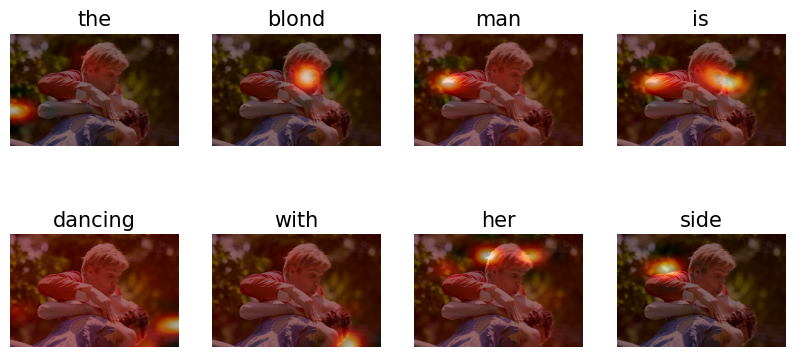

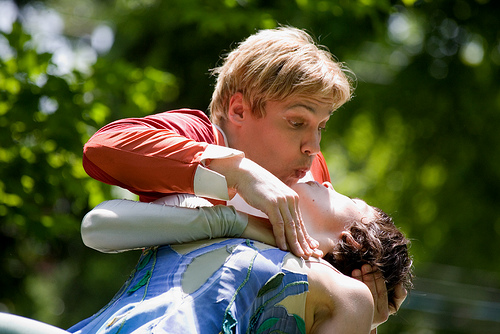

In [53]:
rid = np.random.randint(0, len(path_test))
test_image = path_test[rid]
#test_image = './images/413231421_43833a11f5.jpg'
#real_caption = '<start> black dog is digging in the snow <end>'

real_caption = ' '.join([tokenizer.index_word[i] for i in cap_test[rid] if i not in [0]])
result, attention_plot,pred_test = evaluate(test_image)


real_caption=filt_text(real_caption)


pred_caption=' '.join(result).rsplit(' ', 1)[0]

real_appn = []
real_appn.append(real_caption.split())
reference = real_appn
candidate = pred_caption.split()

score = sentence_bleu(reference, candidate)
print(f"BLEU score: {score*100}")

print ('Real Caption:', real_caption)
print ('Prediction Caption:', pred_caption)
plot_attmap(result, attention_plot, test_image)


Image.open(test_image)

In [54]:
captions=beam_evaluate(test_image)
print(captions)

(['<start>', 'the', 'woman', 'with', 'his', 'hair'], array([[9.48299328e-10, 1.98965342e-08, 6.05044903e-10, 7.95582045e-10,
        3.26792645e-07, 2.55190397e-10, 3.49723889e-10, 2.54349471e-12,
        6.44598856e-07, 3.52426355e-07, 3.37280028e-07, 5.51267639e-02,
        5.93342409e-02, 1.74006838e-02, 3.09160075e-09, 4.13099867e-11,
        4.49705162e-09, 1.18352763e-01, 4.10506040e-01, 4.51532304e-02,
        1.73457700e-03, 1.07858833e-02, 8.64303900e-08, 1.68977332e-11,
        6.88385684e-04, 4.76228446e-03, 8.55934741e-06, 2.50204994e-06,
        5.10046593e-05, 4.26173303e-03, 6.01617728e-07, 6.62974233e-12,
        1.91525873e-02, 3.57091972e-06, 3.16799009e-09, 2.88552099e-10,
        4.75001416e-09, 2.23924199e-05, 7.58676761e-05, 1.57697484e-11,
        2.11970382e-05, 4.17076703e-03, 9.76828787e-08, 2.43986165e-09,
        2.23318075e-09, 4.43050340e-07, 1.96655039e-02, 2.17444249e-08,
        4.70957002e-06, 1.19408473e-01, 7.55400862e-08, 1.78584803e-09,
        9.4

In [55]:
!pip install gtts

In [56]:
# Generate audio for the caption
from gtts import gTTS

gTTS(text = pred_caption, lang = 'en', slow=False).save('captions.mp3')
IPYAudio("captions.mp3", autoplay=False)